<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/classification_with_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Neural Network

In a classification problems, we're trying to predict which class a data point belongs to.

*   **Binary classification** involves categorizing data into only two classes to predict, each instance belongs to either of them.

    Use Case Classifying an image of an animal into cat or dog category.
    
*   **Multiclass classification** involves categorizing data into mutually exclusive classes. Each data point belongs to one and only one class, making it suitable for scenarios where items can be distinctly assigned to one category.

    Use Case: Handwritten Digit Recognition: Assigning a digit (0–9) to a given handwritten image.

*   **Multi-label classification** deals with instances that can be associated with multiple labels simultaneously. This technique is ideal for tasks where data points may belong to more than one class at the same time.

    Use Case: Text Categorization: Labeling articles with multiple topics they cover.

In summary,

| Problem Type | Problem Description |
| ----- | ----- |
| Binary Classification | Target can be one of two options |
| Multi-class Classification | Target can be one of more than two options |
| Multi-label Classification | Target can be assigned more than one option |


# Binary Classification on Scikit-Learn `make-circle()` Dataset

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html

`make-moon()` dataset make a large circle containing a smaller cicle in 2d

## Data Preperation

In [1]:
# Create dataset with scikit-learn
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [2]:
# Turn data into a DataFrame
import pandas as pd
df = pd.DataFrame({"X1": X[:, 0],
                   'X2': X[:, 1],
                   'y': y})
df.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [3]:
# Split data into train and valid sets
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2)

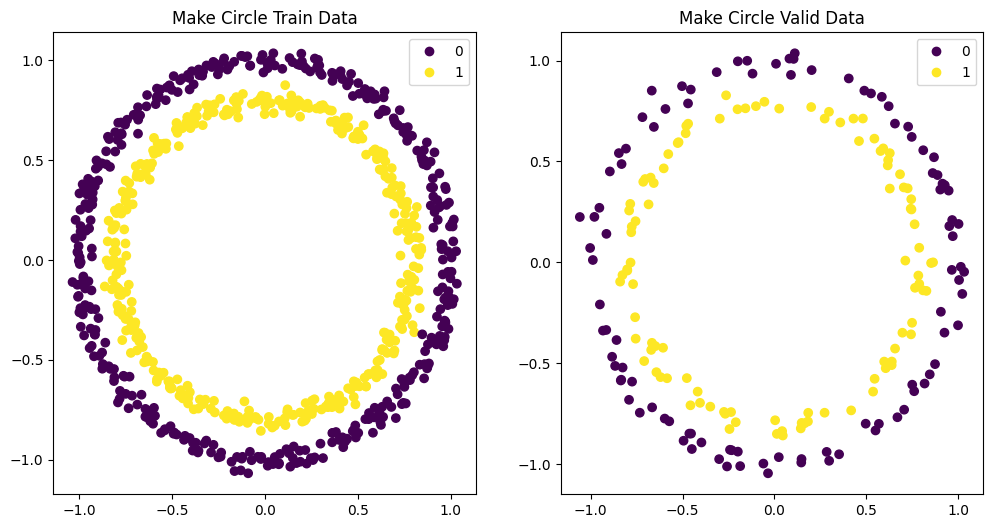

In [4]:
import matplotlib.pyplot as plt

# Visualize both train/valid dataset on a scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter1 = ax1.scatter(df_train['X1'], df_train['X2'], c=df_train['y'], label=df_train['y'])
ax1.legend(*scatter1.legend_elements())
ax1.set(title='Make Circle Train Data')

scatter2 = ax2.scatter(df_valid['X1'], df_valid['X2'], c=df_valid['y'], label=df_valid['y'])
ax2.legend(*scatter2.legend_elements())
ax2.set(title='Make Circle Valid Data');

Using Dataset and DataLoader for both training and valid dataset

In [5]:
import torch
from torch.utils.data import Dataset

class CircleDS(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        X = torch.tensor(df[['X1','X2']].iloc[idx], dtype=torch.float)
        y = torch.tensor(df['y'].iloc[idx], dtype=torch.float)
        return X, y

train_ds = CircleDS(df_train)
valid_ds = CircleDS(df_valid)

In [6]:
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False,
                      drop_last=True)

## Logistic Regression

Given 2 features, X1 and X2, the model will fit a linear regression such that its outputs are logits (z) which are then converted into probabilities using a sigmoid function

$$
P(y=1) = \sigma(z) = \sigma(b + w_1x_1 + w_2x_2)
$$

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/logistic_regression_2inputs.png?raw=true">

In [7]:
import torch
import torch.nn as nn

class SimpleLogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=2, out_features=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, X):
        return self.sigmoid(self.linear(X)).squeeze()

model_0 = SimpleLogisticRegression()
print(model_0)

SimpleLogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Defining a Loss Function for classification problem

For binary classification problem, **binary cross-entropy (BCE) loss** is an appropriate loss/criterion function.

Note that PyTorch has two binary cross entropy implimentation:

1. `nn.BCELoss()` - Creates a loss funciton that measures the binary cross entropy between the target (label) and input (features)

2. `nn.BCEWithLogitsLoss()` - is the same as above except it has a sigmoid layer `nn.Sigmoid()` built in

\

**BCELoss**

Reference: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

BCE Loss requires the predicted probabilities, as returned by the **sigmoid** function, and the true labels ($y$). For each data point $i$ in the training set, it computes the errro as following:

For each data point $i$ in the training set,

1. If the data point belongs to the **positive class (y=1)**, we take the $\log$ of predicted probability that it is positive:

$$
y_i = 1 \implies error_i = \log(P(y_i=1))
$$

2. If the data point belows to the **negative class(y=0)**, we take the log of probability that is negative:

$$
y_i=0 \implies error_i = \log(1-P(y_i=1))
$$

Note that if data point belongs to positive, its prob should be close to 1, which would result in a zero loss from taking the $\log(1)$

errors are then aggregated into teh loss value as below:

\

$$
BCE(y) = -\frac{1}{N}\sum_{i=1}^N[y_i\log(P(y_i=1)) + (1-y_i)\log(1-P(y_i=1))]
$$

\

Note that the points in the **positive class (y=1)** have their second term equal to zero by multiplying to $(1-y_i)$ while points in the **negative class (y=0)** have their first term equal to zero by multiplying to $y_i$

\

**BCEWithLogitsLoss**

BCEWithLogitsLoss takes logits as an argument instead of probabilities. It means that we should not add a `nn.Sigmoid()` as the last layer of our model when using `BCEWithLogitsLoss`. This loss combines both the `Sigmoid` layer and `BCELoss` into one function.

Note that we shoudl not be mixing `nn.Sigmoid` and `nn.BCEWithLogitsLoss` together. When we use `nn.BCEWithLogitsLoss`, we do not put `nn.Sigmoid` in the last layer.





In [8]:
loss_fn = nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

## Defining a metric function

In Machine Learning, the efficiency of a model is not just about its ability to make predictions but also to make the right ones. Practioners use evaluation metrics to understand how well a model performs its intended task. The most important metrics for classification performance are namely **accuracy**, **precision** and **recall**

**Accuracy** is a metric that measures how often a machine learning model correctly predicts the outcome. You can calculate accuracy by dividing the number of correct predictions by the total number of predictions. While it is the most intuitive metrics, it may be insufficient in situations with imbalanced classes or different error costs. **Precision** and **Recall** address the gap. **Precision** measures how often predictions for a positive class are correct while **Recall** address how well the model fins all positive instances in the dataset.

To understand the differentiations of the metrics, we have to understand the **Confusion Matrix**.

\

**The Confusion Matrix**

The confusion matrix is a visual representation to access their model's accuracy in different areas. For binary classification problem, it can be represented as below:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/confusion_matrix.png?raw=true">


At its core, the confusion matrix is a table that compares the actual outcomes with the predicted outcomes of a classifcation model. It is pivotal in understanding the nuances of a model's perfmrance, especially in scenarios where class imabalnces exist or where the cost of different types of errors varies. Breakdown down the prediction into specific categories provides a granular view of a more informed decision-making process to optimize models.

**Elements of Confusion Matrix**

*   **True Positive (TP)** - instances where the model correctly predicted the positive class.
*   **True Negative (TN)** - instances where model accurately predicted the negative classes
*   **False Positive (FP)** - instances where model incorrectly predicted the positive class
*   **False Negative (FN)** - instances where model fails to identify the positive class, marking it as negative instead.

**Accuracy**

\

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

Accuracy represents the ratio of correctly predicted instances to the total number of instances in teh dataset. It answers the question: "Out of all the prediction made, how many were correct?" Accuracy is often the first metric to consider when evaluating classification models.

\

**Precision**

\

$$
Precision = \frac{TP}{TP+FP}
$$

Precision is a pivotal metric especiall if there is a high cost of false positives. It provides insight into the model's ability to correctly predict positive instances while minimizing the risk of a false alarms. Precision is often referred to as the positive predictive value, quantifies the proportion of true positive predictions among all positive predictions made by the model. It answers the question: "Of all the instances predict as postiive, how may were positive?" Precision solely focuses on the correctly predicted positive cases, neglecting the false negatives. As a reslt, a model can achieve high precision by making very few positive predictions, potentially missing out on many actual positive cases.

\

**Recall**

\

$$
Recall = \frac{TP}{TP+FN}
$$

Recall also known as sensitivity or true positive rate, that emphasizes the model ability to identify all relevant instances. Recall measures the proportion of actual positive cases correctly identified by the model. It answers the question: "Of all the acutal positive instances, how many were correctly predicted by the model?". The recall metric is about finding all positive cases, even with more false positives. A model may predict most instances as postive to achieve a high recall.

\

**F1 Score**

As we have seen there is a trade-off between precisiona nd recall, F1 can therefore be used to measure how effectively our models make that trade-off.

$$
F1 = 2 \times \frac{precision \times recall}{precision+recall}
$$

One important feature of the F1 score is that the result is zero if any of the comonents (precision or recall) fall to zero. Thereby it penalizes extreme negative values of either component.

\

**To summarise:**

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/confusion_matrix_metric_calculation.png?raw=true">

Since in our case, we are dealing with binary classification, our ideal outputs are 0 or 1. Since our last layer is `nn.Sigmoid`, we are outputing the prediction probabilities of how much the model thinks the datapoint belows to one class or another. We can use 0.5 as our decision boundary as follow:

*   if `y_preds` >= 0.5, y=1
*   if `y_preds` < 0.5, y=0

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def metric_fn(y_preds, y):
    # Turn into numpy to use sklearn.metrics
    y_preds = np.round(y_preds.detach().cpu().numpy())
    y = y.detach().cpu().numpy()

    # Calculate scores from using sklearn.metrics
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds, average='binary')
    recall = recall_score(y, y_preds, average='binary')
    f1 = f1_score(y, y_preds, average='binary')

    # SSTLearner supports returning a dictionary from metric_fn
    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1}

## Importing SSTLearner

In [10]:
# Installing sstorch package
!pip -q install git+https://github.com/ronald-hk-chung/sstorch.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 20.0 MB/s eta 0:00:00


In [12]:
from sstorch.learner import SSTLearner

## Train model_0 - Logistic Regression

In [35]:
class Model0Learner(SSTLearner):
    def __init__(self):
        super().__init__(model=model_0,
                         loss_fn=loss_fn,
                         metric_fn=metric_fn,
                         train_dataloader=train_dl,
                         valid_dataloader=valid_dl)

    def configure_optimizer(self):
        return torch.optim.SGD(params=self.model.parameters(),
                               lr=0.1)


In [36]:
model_0_learner = Model0Learner()

In [37]:
model_0_learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-01 | train_loss: 0.71 | valid_loss: 0.719 
train_metric: {'accuracy': 0.478, 'precision': 0.467, 'recall': 0.389, 'f1': 0.421}
valid_metric: {'accuracy': 0.427, 'precision': 0.453, 'recall': 0.37, 'f1': 0.405}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-01 | train_loss: 0.703 | valid_loss: 0.709 
train_metric: {'accuracy': 0.472, 'precision': 0.47, 'recall': 0.412, 'f1': 0.433}
valid_metric: {'accuracy': 0.438, 'precision': 0.463, 'recall': 0.389, 'f1': 0.421}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-01 | train_loss: 0.699 | valid_loss: 0.702 
train_metric: {'accuracy': 0.478, 'precision': 0.481, 'recall': 0.409, 'f1': 0.432}
valid_metric: {'accuracy': 0.422, 'precision': 0.448, 'recall': 0.401, 'f1': 0.421}
----------------------------------------------------------------------------------------------------
Epoc

Model_0 - Logistic Regression failed to learn for the non-linear classification data.

To understand why, it is easier to plot out the decision boundary